In [1]:
from pathlib import Path
import random
import warnings

from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from patterns_search.searchers import CorrelationSearcher
from patterns_search.utils import scale_curve
from patterns_search.types import Target

random.seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
rcParams["figure.figsize"] = (8, 9)  # Plots' size

In [3]:
def plot_well_log(depth: np.array, sp: np.array, title: str = "", ax=None):
    if ax is None:
        ax = plt.subplot()
    ax.plot(sp, depth)
    ax.set_xlim(1.1, 0)
    ax.invert_yaxis()
    ax.set_title(title)
    return ax

In [4]:
def fix_pattern_depth(depth: np.array):
    new_dept = np.arange(min(depth), max(depth)+.0001, 0.1)
    return new_dept

## Поиск кривой Муромцева

Поищем кривые Муромцева в скважинах. Для этого распакуйте в папку `data/Murom/` содержимое архива `Murom.rar`. Или любые другие файлы, которые вам нравятся. Единственное ограничение: это должны быть Excel-файлы, содержащие колонки "Dept" и "SP"

In [5]:
muroms_path = Path("data/Murom/")

patterns = {
    file.name: pd.read_excel(file, usecols=["Dept", "SP"]) for file in muroms_path.glob("*")
}

У некоторых паттернов есть пропущенные значения в глубине. Исправим это

In [6]:
for pattern_name, pattern in patterns.items():
    if pattern["Dept"].isna().sum():
        print(pattern_name)
        print("Before:")
        print(pattern["Dept"].isna().sum())

        pattern["Dept"] = fix_pattern_depth(pattern["Dept"])

        print("After:")
        print(pattern["Dept"].isna().sum())
        print("-" * 20)

Alluvial_Боковых русел и проток меандрирующих рек.xlsx
Before:
4
After:
0
--------------------
Alluvial_Русел рек ветвящегося(фуркирующего) типа.xlsx
Before:
28
After:
0
--------------------
Alluvial_Русел рек интенсивно меандрирующего типа, переходящих в старичные озёра.xlsx
Before:
8
After:
0
--------------------
Alluvial_Русел рек ограниченно меандрирующего типа.xlsx
Before:
28
After:
0
--------------------
Delta_Верхняя надводная равнина.xlsx
Before:
84
After:
0
--------------------
Delta_Глинистые отложения мелководной части морского шельфа.xlsx
Before:
16
After:
0
--------------------
Delta_Морской край.xlsx
Before:
24
After:
0
--------------------
Delta_Нижняя надводная равнина.xlsx
Before:
40
After:
0
--------------------
Delta_Подводная равнина.xlsx
Before:
20
After:
0
--------------------
Delta_Подводный склон.xlsx
Before:
60
After:
0
--------------------
Delta_Русловые отмели реки, формирующей дельту.xlsx
Before:
284
After:
0
--------------------
Shallow marine_Барьерных ост

Прочитаем данные, в которых будем искать кривую

In [7]:
df = pd.read_pickle("data/New_dataset.pkl")
df.head(3)

,Well,Top,Bottom,Thickness,ind_top,ind_bot,sp,dept,code
0,101P_y-kin,2890.89,2924.37,33.48,28895,29230,"[146.83500671, 146.7230072, 145.58999634, 144....","[2890.88, 2890.98, 2891.08, 2891.18, 2891.28, ...","[nan, nan, nan, nan, nan, nan, nan, nan, 16.0,..."
1,105_unt,2886.79,2899.94,13.15,1384,1450,"[137.37800598, 137.75500488, 138.05000305, 138...","[2886.8, 2887.0, 2887.2, 2887.4, 2887.6, 2887....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,107_unt,2912.93,2930.13,17.2,9649,9700,"[113.917099, 113.74120331, 113.51339722, 113.2...","[2913.02, 2913.22, 2913.42, 2913.62, 2913.82, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [8]:
targets = [Target(sp=row.sp, depth=row.dept, name=row.Well) for _, row in df.iterrows()]

Попробуем найти конкретную кривую Муромцева в нескольких скважинах:

In [9]:
pattern_name = "Alluvial_Береговых валов.xlsx"
pattern = patterns[pattern_name]

searcher = CorrelationSearcher(n_augmentations=30)
searcher.fit(pattern=pattern["SP"].to_numpy())

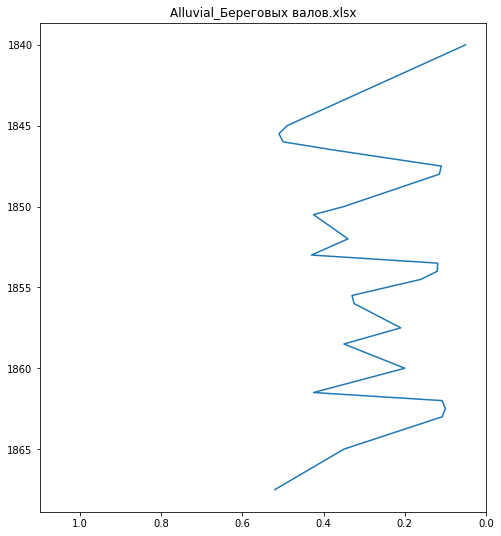

In [10]:
plot_well_log(pattern["Dept"], pattern["SP"], title=pattern_name);

In [11]:
thresholds = [0.8, 0.9, 0.95]

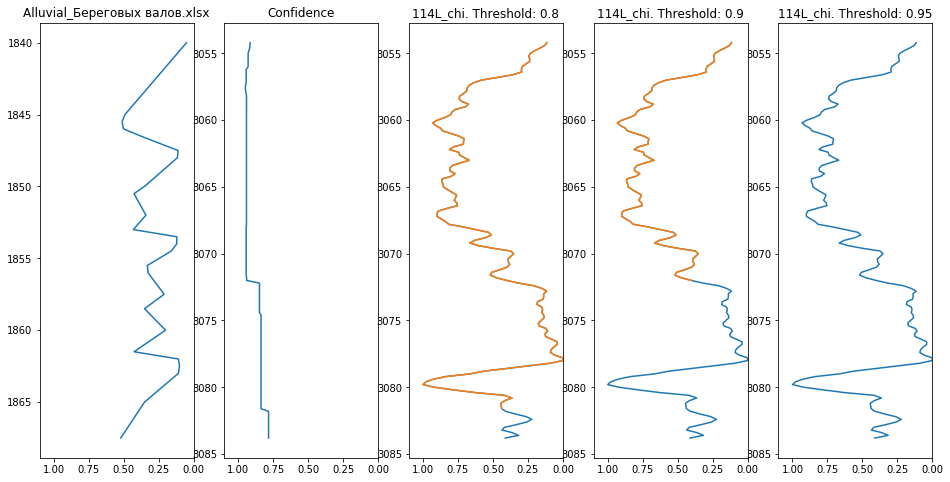

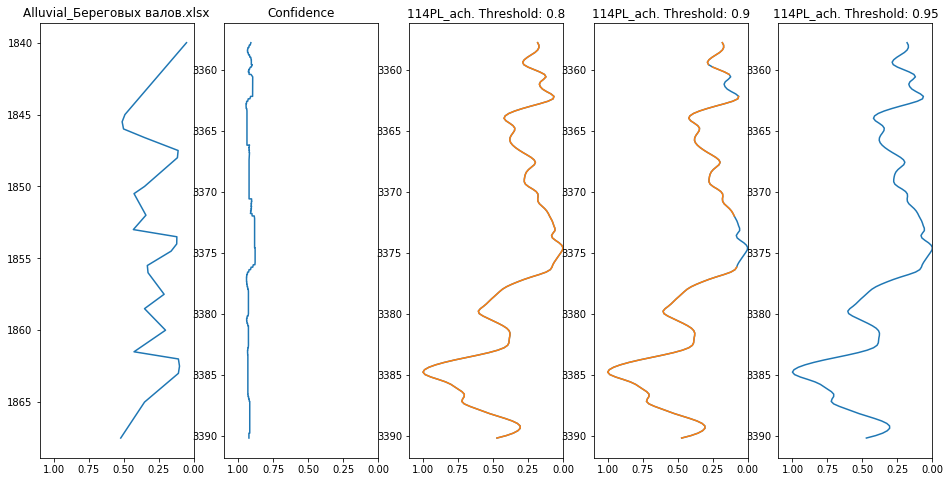

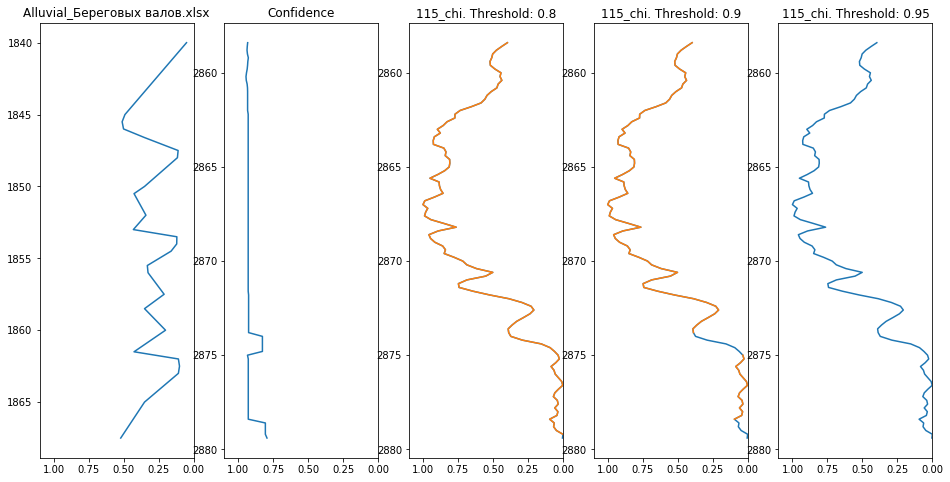

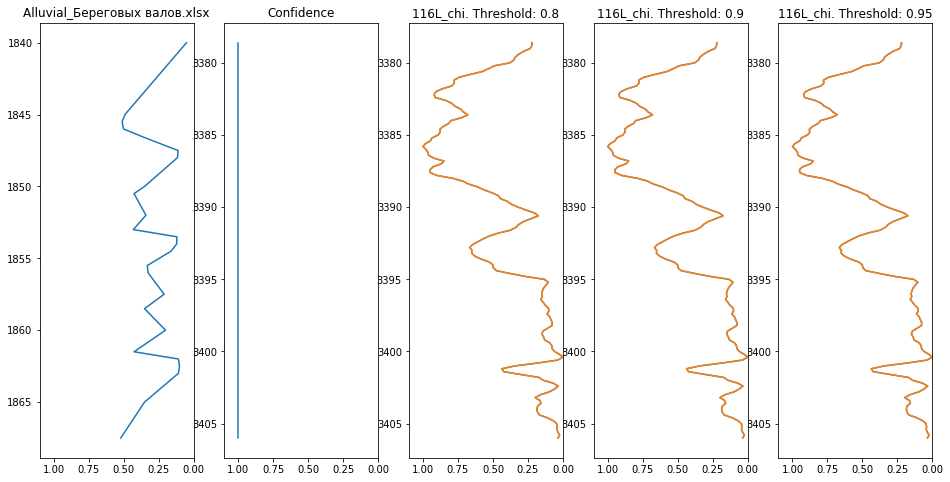

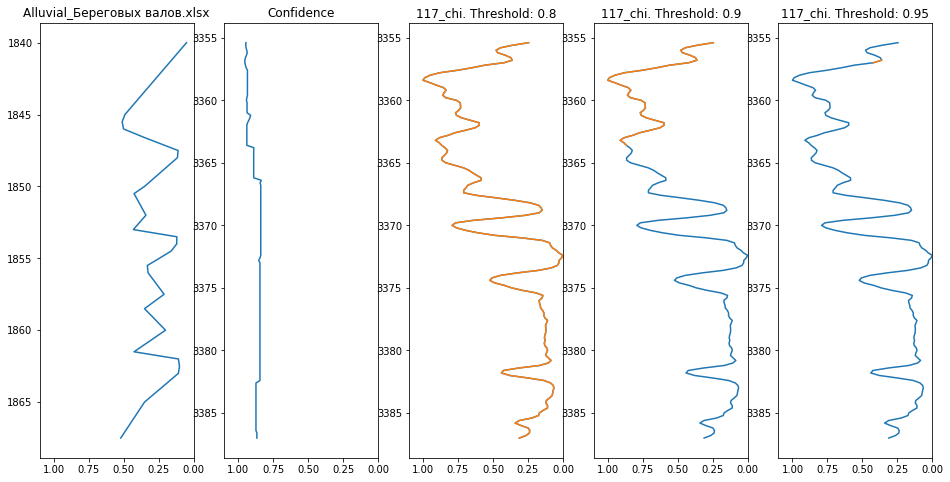

In [12]:
start = 10

for target in targets[start: start + 5]:
    scaled_sp = scale_curve(target.sp)

    prediction = searcher.predict(scaled_sp)

    if all(prediction < min(thresholds)): 
        continue

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 8))
    plot_well_log(sp=pattern["SP"], depth=pattern["Dept"], ax=axes[0], title=pattern_name)
    plot_well_log(sp=prediction, depth=target.depth, ax=axes[1], title="Confidence")

    for i in range(3):
        threshold = thresholds[i]
        ax = axes[i+2]

        more_than_threshold = prediction > threshold
        highlighted_sp = scaled_sp.copy()
        highlighted_sp[~more_than_threshold] = np.nan
        highlighted_depth = target.depth.copy()
        highlighted_depth[~more_than_threshold] = np.nan

        plot_well_log(sp=scaled_sp, depth=target.depth, ax=ax)
        plot_well_log(
            sp=highlighted_sp, depth=highlighted_depth, ax=ax, title=f"{target.name}. Threshold: {threshold}"
        )
        ax.invert_yaxis()

    plt.show()

In [13]:
raise Exception

Exception: 

In [ ]:
save_path = Path("C:/Users/vladi/OneDrive/Documents/Programming/Muroms/results/5_correlation_with_covering/")

In [ ]:
thresholds = [0.8, 0.9, 0.95]

for pattern_name, pattern in tqdm(patterns.items()):
    searcher = CorrelationSearcher()
    searcher.fit(pattern=pattern["SP"].to_numpy())
        
    for target in targets:
        scaled_sp = scale_curve(target.sp)
    
        prediction = searcher.predict(scaled_sp)
        
        if all(prediction < min(thresholds)):
            continue

        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 8))
        plot_well_log(sp=pattern["SP"], depth=pattern["Dept"], ax=axes[0], title=pattern_name)
        plot_well_log(sp=prediction, depth=target.depth, ax=axes[1], title="Confidence")

        for i in range(3):
            threshold = thresholds[i]
            ax = axes[i+2]
            
            more_than_threshold = prediction > threshold
            sp_copy = scaled_sp.copy()
            sp_copy[~more_than_threshold] = np.nan
            depth_copy = target.depth.copy()
            depth_copy[~more_than_threshold] = np.nan

            plot_well_log(sp=scaled_sp, depth=target.depth, ax=ax)
            plot_well_log(
                sp=sp_copy,
                depth=depth_copy,
                ax=ax,
                title=f"{target.name}. Threshold: {threshold}",
            )
        
        plt.savefig(save_path / f"{pattern_name} in {target.name}.png")
        plt.cla()
        plt.close(fig)

In [15]:
my_list = [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1]
answer = [my_list[0]]

for x in my_list:
    if x != answer[-1]:
        answer.append(x)
        
answer

[1, 2, 3, 1]